In [3]:
# importing functions for analysis
# I find I have to run this cell twice to get nice, large plots
from functions import *

In [4]:
# loading the data sets

# main detector
data_dict, norm_dict = load_all_main(raw_unix_time_flag = True)

# Time Constant of Detection Peak Tail

To determine the diffuse reflection probability the time constant of the exponential decay that occurs following the main detection peak, must be fitted. In the plots below we see the precise region of the time-of-flight spectrum that must be analyzed.

Total detected counts: 106378.0


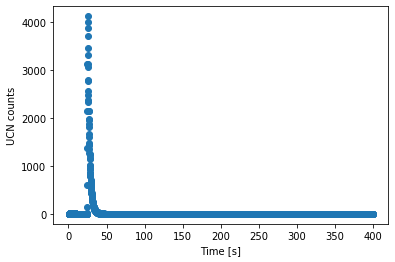

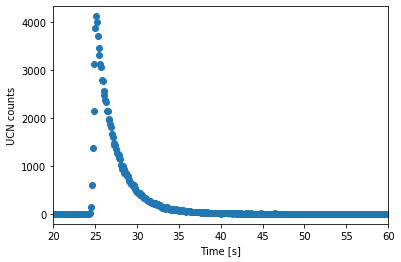

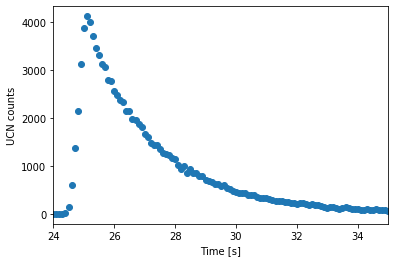

In [5]:
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()

data = np.loadtxt("../data_ucn/main_detector/8/T081217_0034.tof", usecols = (0,1));
ax1.scatter(data[:,0] * 0.1, data[:,1]);
ax1.set_ylabel('UCN counts');
ax1.set_xlabel('Time [s]');

ax2.scatter(data[:,0] * 0.1, data[:,1]);
ax2.set_ylabel('UCN counts');
ax2.set_xlim([20,60])
ax2.set_xlabel('Time [s]');

ax3.scatter(data[:,0] * 0.1, data[:,1]);
ax3.set_ylabel('UCN counts');
ax3.set_xlim([24,35])
ax3.set_xlabel('Time [s]');
fig3.savefig('../img/detection_tail.pdf')

print('Total detected counts: {}'.format(np.sum(data[:,1])))

# Normalization Configurations

It is not yet clear whether or not the guided measurements will be sensitive to changes in the diffuse reflection probabilities of the guides themselves. To begin with, we'll fit decaying exponential functions to the data from the normalization runs. This will enable matching within the simulations, and the selection of diffuse reflection probability values for every material except that of the guides.

[[Model]]
    Model(expo)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 82
    # data points      = 3749
    # variables        = 2
    chi-square         = 823.800484
    reduced chi-square = 0.21985601
    Akaike info crit   = -5676.91986
    Bayesian info crit = -5664.46137
[[Variables]]
    p0:  18.4775627 +/- 0.01833680 (0.10%) (init = 80)
    p1: -0.04083699 +/- 6.6450e-05 (0.16%) (init = -0.2)
[[Correlations]] (unreported correlations are < 0.100)
    C(p0, p1) = -0.996



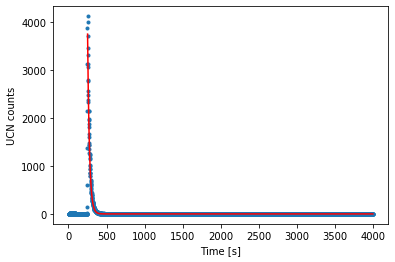

In [6]:
# load data from an example run 
arr = np.loadtxt("../data_ucn/main_detector/8/T081217_0034.tof", usecols = (0,1));

# exponential function, same as ROOT's built-in 'expo'
def expo(x, p0, p1):
    return np.exp(p0 + p1 * x)

# We perform the fit on all of the data occurring after the peak count
# bin is observed
_counts = arr[:, 1]
max_index = _counts.argmax()
t = arr[max_index:-1, 0]
counts = _counts[max_index:-1]

# construct weights, we deal with entries = 0 by giving them 0 weight
weights = np.zeros(np.shape(counts))
for i in range(0,np.shape(counts)[0]):
    if (counts[i] != 0):
        weights[i] = 1 / np.sqrt(counts[i])
    else:
        weights[i] = 0
        
gmodel = Model(expo)
result = gmodel.fit(counts, x=t, p0=80, p1=-0.2, weights = weights)

print(result.fit_report())
plt.plot(arr[:,0], arr[:,1], '.')
plt.plot(t, result.best_fit, 'r-')
plt.ylabel('UCN counts')
plt.xlabel('Time [s]')
plt.savefig('../img/rough_tail_fit.pdf')
plt.show()

This method required a rather hand-wavy cut of the data. I'm just taking all of the data recorded after the maximum count value, and including that maximum value. This extremely rough approach should be reconsidered, and replaced with some kind of combined fit of the rising peak, and the ensuing decay. 

Now we perform this operation iteratively on every run carried out in the TRIUMF-style normalization configuration, and in the JP-style normalization configuration. The values for $\tau$ are averaged within each pre-storage-time-specific data set, and plotted below.

T101217_0135_NOMI_s005.tof
T101217_0251_NOMI_s005.tof
T101217_0136_NOMI_s005.tof
T081217_0035_NOMI_s005.tof
T081217_0034_NOMI_s005.tof
T101217_0134_NOMI_s005.tof
T091217_0122_NOMI_s005.tof
T081217_0078_NOMI_s005.tof
T101217_0184_NOMI_s005.tof
T101217_0183_NOMI_s005.tof
T091217_0187_NOMI_s005.tof
T091217_0121_NOMI_s005.tof
T101217_0252_NOMI_s005.tof
T081217_0079_NOMI_s005.tof
T091217_0123_NOMI_s005.tof
T081217_0077_NOMI_s005.tof
T101217_0185_NOMI_s005.tof
T081217_0033_NOMI_s005.tof
T081217_0032_NOMI_s005.tof
T091217_0188_NOMI_s005.tof
T091217_0189_NOMI_s005.tof
T101217_0250_NOMI_s005.tof
(NOMI,s005): -0.038695+/-0.000014
T081217_0080_NOMI_s020.tof
T101217_0254_NOMI_s020.tof
T101217_0132_NOMI_s020.tof
T091217_0124_NOMI_s020.tof
T081217_0023_NOMI_s020.tof
T091217_0185_NOMI_s020.tof
T101217_0133_NOMI_s020.tof
T091217_0184_NOMI_s020.tof
T101217_0180_NOMI_s020.tof
T091217_0127_NOMI_s020.tof
T081217_0081_NOMI_s020.tof
T101217_0253_NOMI_s020.tof
T101217_0181_NOMI_s020.tof
T101217_0131_NOMI_s02

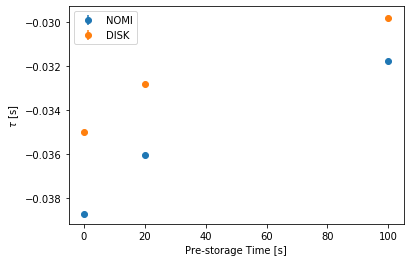

In [7]:
# dictionary to hold time constant values
tau_dict   = {} 

fig, ax = plt.subplots()
ax_c = plt.gca()

for config in ['NOMI', 'DISK']:
    
    color = next(ax_c._get_lines.prop_cycler)['color']
    
    for run_type in ['s005', 's020', 's100']:
        
        # we'll save tau and error
        tau_dict[config, run_type] = np.empty((0,2), float)

        for filename in os.listdir('../data_ucn/main_detector_sorted'):

            # Only the files matching our desired configuration and run 
            # type are selected. The '.tof' condition is just so we 
            # don't perform the analysis twice per run (since it would
            # otherwise match to the .tof and the .txt files)
            if ((config in filename) and (run_type in filename) and 
            ('.tof' in filename)):

                # The data is retrieved from the .tof file
                arr = np.loadtxt('../data_ucn/main_detector_sorted/' + 
                                        filename[0:22] + '.tof',
                                        usecols = (0,1))
                
                # this if/else sequence handles cuts of the data, which for 
                # some runs is specific based on the experimental 
                # conditions
                # specific data cut for run 35 on the 8th
                if ((filename[2:3] == '8') and 
                    (filename[10:12] == '35')):
                    
                    _counts = arr[0:1000, 1]
                    t = arr[0:1000,0]

                # specific data cut for run 66 on the 8th
                elif ((filename[2:3] == '8') and 
                        (filename[10:12] == '66')):

                    _counts = arr[0:1500, 1]
                    t = arr[0:1500,0]

                # specific data cut for run 88 on the 8th
                elif ((filename[2:3] == '8') and 
                        (filename[10:12] == '88')):

                    _counts = arr[0:2500, 1]
                    t = arr[0:2500,0]
                    
                else:
                    _counts = arr[:, 1]
                    t = arr[:,0]
                
                max_index = _counts.argmax()
                t = t[max_index:-1]
                counts = _counts[max_index:-1]
                
#                 print('t shape = {}'.format(np.shape(t)))
#                 print('counts shape = {}'.format(np.shape(counts)))
                print(filename)
                # construct weights, we deal with entries = 0 by giving them 0 weight
                weights = np.zeros(np.shape(counts))
                for i in range(0,np.shape(counts)[0]):
                    if (counts[i] != 0):
                        weights[i] = 1 / np.sqrt(counts[i])
                    else:
                        weights[i] = 0
                
                gmodel = Model(expo)
                result = gmodel.fit(counts, x=t, p0=80, p1=-0.01, weights = weights)

#                 print(result.fit_report())
#                 plt.plot(t, counts, 'bo')
#                 plt.plot(t, result.best_fit, 'r-')
#                 plt.show()

                day_run_no = int(filename[1:3]) + (0.001
                                   * int(filename[9:12]))

                tau_dict[config, run_type] = np.append(
                    tau_dict[config, run_type], 
                    [[result.params['p1'].value, result.params['p1'].stderr]],
                    axis=0)
        
        # finished with given [config, run_type]
        # generate uncertainty array of data set, calculate mean, add to dict
        arr = tau_dict[config, run_type]
        uarr = unumpy.umatrix(arr[:,0], arr[:,1])
        ave_tau = uarr.mean(1)[0,0]

        storage_time = int(run_type[1:-1])

        # add mean value to plot
        # JP-style
        if (config == 'DISK'):

            ax.errorbar(storage_time * 10, ave_tau.nominal_value, yerr = ave_tau.std_dev, 
                          fmt = 'o', label = config, color = color)

        # TRIUMF-style
        else:
            ax.errorbar(storage_time * 10, ave_tau.nominal_value, yerr = ave_tau.std_dev, 
                          fmt = 'o', label = config, color = color)
            
        print('(' + config + ',' + run_type + '): {}'.format(ave_tau))
                               
# presentation stuff
ax.set_ylabel(r'$\tau$ [s]');
ax.set_xlabel('Pre-storage Time [s]')
ax.legend();
handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys());   
fig.savefig('../img/all_norm_tail_fits.pdf')

## NOTE: These results have not used the source normalization at all, could this explain the depressed values for NOMI? NOMI represents the TRIUMF-style normalization measurements, which were carried out over the entire experimental campaign. Thus, they are more sensitive to the source decay that took place. Is this result consistent physically with what we expect happens to the energy spectrum due to the sD2 frost?

We can come back and perform the source normalization on this data, but for now this result can be used to fit the diffuse reflection probability. Any change due to the normalization will only change the probability value slightly, and also affect the error bar. We want to get quickly to the point where we can see if any of this matters for the guided measurements. 